In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.models import load_model

from sklearn.metrics import mean_absolute_error



Using TensorFlow backend.


In [2]:
def change_number(unique_lst):
    unique = pd.DataFrame(unique_lst).reset_index()
    indexes = unique['index']
    ids = unique[0]
    tuple_zip = list(zip(ids, indexes))
    dic = dict((x, y) for x, y in tuple_zip)
    reverse_dic = dict((y, x) for x, y in tuple_zip)
    return dic, reverse_dic

### Make number of users

In [3]:
ratings2 = pd.read_csv('ratings_breakfast.csv')

rating_count2 = ratings2.groupby('recipe_id')['rating'].count().reset_index()
rating_count = rating_count2.rename(columns = {'rating':'review_count'})

threshold = 10
rating_count = rating_count.query('review_count >= @threshold')
rating_count

recipe_rating = pd.merge(rating_count, ratings2, left_on='recipe_id', right_on='recipe_id', how='left')

user_count2 = ratings2.groupby('user_id')['rating'].count().reset_index()
user_count = user_count2.rename(columns = {'rating':'user_count'})
    
threshold = 10
user_count = user_count.query('user_count >= @threshold')

ratings = pd.merge(user_count, recipe_rating, left_on = 'user_id', right_on = 'user_id', how = 'inner')

ratings.to_csv('result_breakfastMF.csv', index=False)


In [4]:
unique_users = list(ratings['user_id'].unique())
unique_recipe = list(ratings['recipe_id'].unique())

### Make users and recipe id van 0 tot eind 

In [5]:
dic_user, dummy = change_number(unique_users)

ratings['user_id'] = ratings['user_id'].replace(dic_user)

In [6]:
dic_recipe, dic_recipe_reverse = change_number(unique_recipe)

ratings['recipe_id'] = ratings['recipe_id'].replace(dic_recipe)

### Scale 

In [7]:
scaler = MinMaxScaler()
ratings['rating'] = ratings['rating'].values.astype(float)
rating_scaled = pd.DataFrame(scaler.fit_transform(ratings['rating'].values.reshape(-1,1)))
ratings['rating'] = rating_scaled

### Split

In [8]:
train, test = train_test_split(ratings, test_size=0.2)

Number of users and items

In [9]:
n_users = ratings.user_id.nunique()
print('users', n_users)
n_items = ratings.recipe_id.nunique()
print('recipe', n_items)

users 945
recipe 1473


### Drop

In [12]:
ratings = ratings.drop(columns = ['user_count', 'review_count'])

KeyError: "['user_count' 'review_count'] not found in axis"

### Make model

In [13]:
recipe_input = Input(shape=[1], name="Recipe-Input")

recipe_embedding = Embedding(n_items+1, 20, name="Recipe-Embedding")(recipe_input)
recipe_vec = Flatten(name="Flatten-Recipe")(recipe_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 20, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([recipe_vec, user_vec])
model = Model([user_input, recipe_input], prod)
model.compile(loss = 'mean_absolute_error', optimizer='adam')

### Train model

In [20]:
history = model.fit([train.user_id, train.recipe_id], train.rating, epochs=150, verbose=1)
model.save('Breakfast_MF_U10R10_noscale.h5')

Epoch 1/150
12063/12063 [==============================] - 1s 66us/step - loss: 0.0638
Epoch 2/150
12063/12063 [==============================] - 1s 64us/step - loss: 0.0635
Epoch 3/150
12063/12063 [==============================] - 1s 93us/step - loss: 0.0633
Epoch 4/150
12063/12063 [==============================] - 1s 88us/step - loss: 0.0635
Epoch 5/150
12063/12063 [==============================] - 1s 81us/step - loss: 0.0630
Epoch 6/150
12063/12063 [==============================] - 1s 81us/step - loss: 0.0639
Epoch 7/150
12063/12063 [==============================] - 1s 73us/step - loss: 0.0625
Epoch 8/150
12063/12063 [==============================] - 1s 76us/step - loss: 0.0631
Epoch 9/150
12063/12063 [==============================] - 1s 93us/step - loss: 0.0624
Epoch 10/150
12063/12063 [==============================] - 1s 79us/step - loss: 0.0631
Epoch 11/150
12063/12063 [==============================] - 1s 75us/step - loss: 0.0628
Epoch 12/150
12063/12063 [===============

12063/12063 [==============================] - 1s 65us/step - loss: 0.0596
Epoch 94/150
12063/12063 [==============================] - 1s 63us/step - loss: 0.0601
Epoch 95/150
12063/12063 [==============================] - 1s 63us/step - loss: 0.0604
Epoch 96/150
12063/12063 [==============================] - 1s 75us/step - loss: 0.0601
Epoch 97/150
12063/12063 [==============================] - 1s 70us/step - loss: 0.0604
Epoch 98/150
12063/12063 [==============================] - 1s 70us/step - loss: 0.0607
Epoch 99/150
12063/12063 [==============================] - 1s 68us/step - loss: 0.0600
Epoch 100/150
12063/12063 [==============================] - 1s 65us/step - loss: 0.0610
Epoch 101/150
12063/12063 [==============================] - 1s 62us/step - loss: 0.0600
Epoch 102/150
12063/12063 [==============================] - 1s 64us/step - loss: 0.0610
Epoch 103/150
12063/12063 [==============================] - 1s 63us/step - loss: 0.0604
Epoch 104/150
12063/12063 [==============

In [38]:
model_breakfast = load_model('Breakfast_MF_U10R10.h5')

/Users/louise/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [39]:
y_hat = np.round(model_breakfast.predict([test.user_id, test.recipe_id]),0)
y_true = test.rating

MAE = mean_absolute_error(y_true, y_hat)

percentage_wrong = MAE/5 * 100
percentage_wrong


1.762599469496021

Text(0, 0.5, 'Train Error')

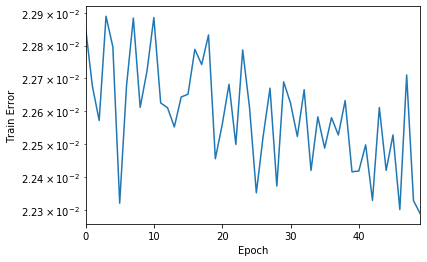

In [40]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [21]:
y_hat = np.round(model.predict([test.user_id, test.recipe_id]),0)
y_true = test.rating

MAE = mean_absolute_error(y_true, y_hat)

percentage_wrong = MAE/5 * 100
percentage_wrong



13.169761273209549

Text(0, 0.5, 'Train Error')

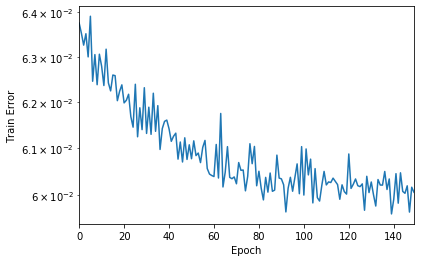

In [22]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

### Make recommendations

In [16]:
recipe_data = np.array(list(set(ratings.recipe_id)))
user = np.array([1 for i in range(len(recipe_data))])
predictions = model_breakfast.predict([user, recipe_data])
predictions = np.array([a[0] for a in predictions])
recommended_recipe_ids = (-predictions).argsort()[:50]
print(recommended_recipe_ids)
print(predictions[recommended_recipe_ids])


[ 208  226  379  740  445 1357  347  990  340   26  656 1061  130  925
  427 1303  441 1208    6  228  236 1383  653 1092   57  374  378  136
 1464 1169  153  807 1040  678  231  849 1101  273  607  166  502  965
 1056  367  384 1369 1010 1257  534  958]
[1.0721616  1.0663731  1.0565736  1.0537348  1.0506839  1.0506386
 1.0423832  1.0393084  1.0379336  1.0373819  1.0372666  1.0369647
 1.0354469  1.032382   1.0270166  1.02404    1.0219494  1.0219322
 1.0213342  1.0185404  1.0173812  1.0163457  1.0150881  1.0149666
 1.0148627  1.014781   1.0111487  1.0103902  1.0097526  1.0088295
 1.0080211  1.0072945  1.0047258  1.0035857  1.0032358  1.0026984
 1.0023458  1.0021333  1.0012635  1.0000384  0.9998802  0.99952954
 0.9989394  0.9984897  0.9981382  0.9978467  0.9977726  0.99767876
 0.99756825 0.99746495]


In [17]:
def recommendation(ratings, model, user_id):
    recipe_ids = ratings.recipe_id.unique()
    user = np.array([user_id for i in range(len(recipe_ids))])

    predictions = model.predict([user, recipe_ids])
    predictions = np.array([a[0] for a in predictions])
    recommended_recipe_ids = (-predictions).argsort()[:500]
    
    return list(zip(recommended_recipe_ids, predictions[recommended_recipe_ids]))

In [18]:
breakfast_recommendations = recommendation(ratings, model_breakfast, 1)
breakfast_recommendations

[(208, 1.0721616),
 (226, 1.0663731),
 (379, 1.0565736),
 (740, 1.0537348),
 (445, 1.0506839),
 (1357, 1.0506386),
 (347, 1.0423832),
 (990, 1.0393084),
 (340, 1.0379336),
 (26, 1.0373819),
 (656, 1.0372666),
 (1061, 1.0369647),
 (130, 1.0354469),
 (925, 1.032382),
 (427, 1.0270166),
 (1303, 1.02404),
 (441, 1.0219494),
 (1208, 1.0219322),
 (6, 1.0213342),
 (228, 1.0185404),
 (236, 1.0173812),
 (1383, 1.0163457),
 (653, 1.0150881),
 (1092, 1.0149666),
 (57, 1.0148627),
 (374, 1.014781),
 (378, 1.0111487),
 (136, 1.0103902),
 (1464, 1.0097526),
 (1169, 1.0088295),
 (153, 1.0080211),
 (807, 1.0072945),
 (1040, 1.0047258),
 (678, 1.0035857),
 (231, 1.0032358),
 (849, 1.0026984),
 (1101, 1.0023458),
 (273, 1.0021333),
 (607, 1.0012635),
 (166, 1.0000384),
 (502, 0.9998802),
 (965, 0.99952954),
 (1056, 0.9989394),
 (367, 0.9984897),
 (384, 0.9981382),
 (1369, 0.9978467),
 (1010, 0.9977726),
 (1257, 0.99767876),
 (534, 0.99756825),
 (958, 0.99746495),
 (1234, 0.99730533),
 (632, 0.99714684),

In [41]:
breakfast_df = pd.DataFrame(breakfast_rec, columns=['recipe_id', 'prediction'])

NameError: name 'breakfast_rec' is not defined

In [42]:
breakfast_df

NameError: name 'breakfast_df' is not defined